# Overfitting and Underfitting
Improve performance with extra capacity or early stopping.

### 📚 Introduction
Keras tracks the training and validation loss over epochs. This lesson focuses on interpreting these learning curves to identify underfitting and overfitting and using strategies to improve the model's performance. 🚀

### 📊 Interpreting the Learning Curves
Training data contains **signal** (useful patterns) 🔍 and **noise** (irrelevant patterns) 🚫. The **training loss** decreases when the model learns either signal or noise, while the **validation loss** only decreases when the model learns signal. If the model learns noise, a gap forms between the training and validation loss, indicating overfitting. ⚠️

To balance signal and noise, we aim to minimize the validation loss, but after a certain point, learning more noise can cause the validation loss to rise, signaling overfitting. ⬆️

### ⚖️ Underfitting and Overfitting
- **Underfitting** occurs when the model doesn’t learn enough signal, resulting in higher training and validation loss. 😞
- **Overfitting** happens when the model learns too much noise, leading to a large gap between training and validation loss. 😬

### 🛠️ Capacity
The model's **capacity** refers to its ability to learn patterns. A model's capacity can be increased by making it:
- **Wider** (more neurons per layer) for learning linear relationships. 🧠
- **Deeper** (more layers) for learning nonlinear relationships. 🧩

### ⏸️ Early Stopping
To prevent overfitting, we can use **early stopping**, which halts training when the validation loss stops improving. This helps avoid overfitting by stopping the model training at the point of minimal validation loss. 🛑


In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.model_selection import GroupShuffleSplit

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import callbacks

spotify = pd.read_csv('dl-course-data/spotify.csv')

X = spotify.copy().dropna()
y = X.pop('track_popularity')
artists = X['track_artist']

features_num = ['danceability', 'energy', 'key', 'loudness', 'mode',
                'speechiness', 'acousticness', 'instrumentalness',
                'liveness', 'valence', 'tempo', 'duration_ms']
features_cat = ['playlist_genre']

preprocessor = make_column_transformer(
    (StandardScaler(), features_num),
    (OneHotEncoder(), features_cat),
)

# We'll do a "grouped" split to keep all of an artist's songs in one
# split or the other. This is to help prevent signal leakage.
def group_split(X, y, group, train_size=0.75):
    splitter = GroupShuffleSplit(train_size=train_size)
    train, test = next(splitter.split(X, y, groups=group))
    return (X.iloc[train], X.iloc[test], y.iloc[train], y.iloc[test])

X_train, X_valid, y_train, y_valid = group_split(X, y, artists)

X_train = preprocessor.fit_transform(X_train)
X_valid = preprocessor.transform(X_valid)
y_train = y_train / 100 # popularity is on a scale 0-100, so this rescales to 0-1.
y_valid = y_valid / 100

input_shape = [X_train.shape[1]]
print("Input shape: {}".format(input_shape))

Input shape: [18]


Let's train a linear model on the Spotify dataset.

c:\Users\samad\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Minimum Validation Loss: 0.1946


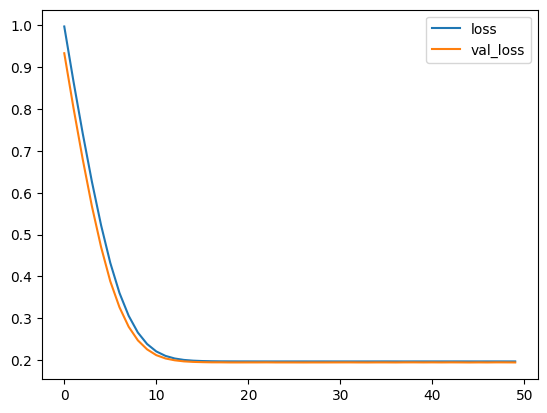

In [2]:
model = keras.Sequential([
    layers.Dense(1, input_shape=input_shape),
])
model.compile(
    optimizer='adam',
    loss='mae',
)
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=512,
    epochs=50,
    verbose=0, # suppress output since we'll plot the curves
)
history_df = pd.DataFrame(history.history)
history_df.loc[0:, ['loss', 'val_loss']].plot()
print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()))

It's not uncommon for the curves to follow a "hockey stick" pattern like you see here. This makes the final part of training hard to see, so let's start at epoch 10 instead:

Minimum Validation Loss: 0.1946


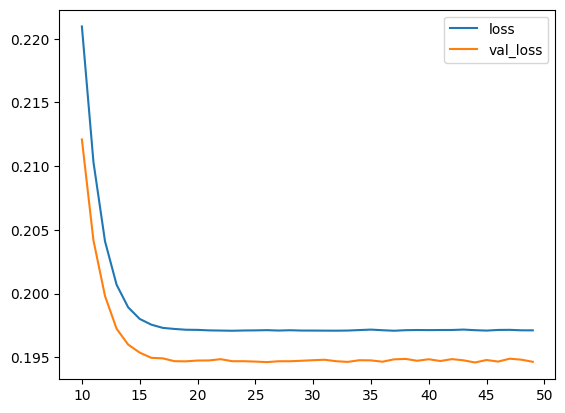

In [3]:
# Start the plot at epoch 10
history_df.loc[10:, ['loss', 'val_loss']].plot()
print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()));

# 1) Evaluate Baseline

What do you think? Would you say this model is underfitting, overfitting, just right?

-->>> The gap between these curves is quite small and the validation loss never increases, so it's more likely that the network is underfitting than overfitting. It would be worth experimenting with more capacity to see if that's the case.

Now let's add some capacity to our network. We'll add three hidden layers with 128 units each. 

Epoch 1/50


c:\Users\samad\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.3497 - val_loss: 0.2067
Epoch 2/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2052 - val_loss: 0.2002
Epoch 3/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2000 - val_loss: 0.1981
Epoch 4/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1967 - val_loss: 0.1970
Epoch 5/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1933 - val_loss: 0.1956
Epoch 6/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1917 - val_loss: 0.1953
Epoch 7/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1904 - val_loss: 0.1954
Epoch 8/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1891 - val_loss: 0.1961
Epoch 9/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1883 - val_loss: 0.1942
Epoch 10/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1867 - val_loss: 0.1944
Epoch 11/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1867 - val_loss: 0.1945
Epoch 12/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1840 - val_loss: 0.1941


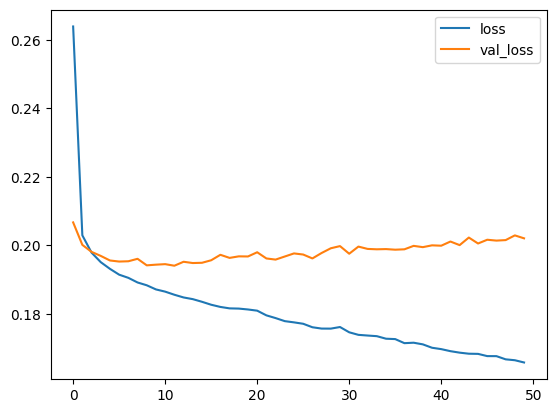

In [4]:
model = keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=input_shape),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
])
model.compile(
    optimizer='adam',
    loss='mae',
)
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=512,
    epochs=50,
)
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()))

# 2) Add Capacity

What is your evaluation of these curves? Underfitting, overfitting, just right?

--->>>Now the validation loss begins to rise very early, while the training loss continues to decrease. This indicates that the network has begun to overfit. At this point, we would need to try something to prevent it, either by reducing the number of units or through a method like early stopping. (We'll see another in the next lesson!)

# 3) Define Early Stopping Callback

Now define an early stopping callback that waits 5 epochs (`patience'`) for a change in validation loss of at least `0.001` (`min_delta`) and keeps the weights with the best loss (`restore_best_weights`).

In [7]:
from tensorflow.keras import callbacks

#  define an early stopping callback
early_stopping = callbacks.EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=5, # how many epochs to wait before stopping
    restore_best_weights=True,
)


Epoch 1/50


c:\Users\samad\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.3883 - val_loss: 0.2104
Epoch 2/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2108 - val_loss: 0.2008
Epoch 3/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2013 - val_loss: 0.1975
Epoch 4/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1957 - val_loss: 0.1966
Epoch 5/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1927 - val_loss: 0.1967
Epoch 6/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1900 - val_loss: 0.1956
Epoch 7/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1888 - val_loss: 0.1952
Epoch 8/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1882 - val_loss: 0.1945
Epoch 9/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1873 - val_loss: 0.1944
Epoch 10/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1862 - val_loss: 0.1948
Epoch 11/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1857 - val_loss: 0.1946
Epoch 12/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1843 - val_loss: 0.1948


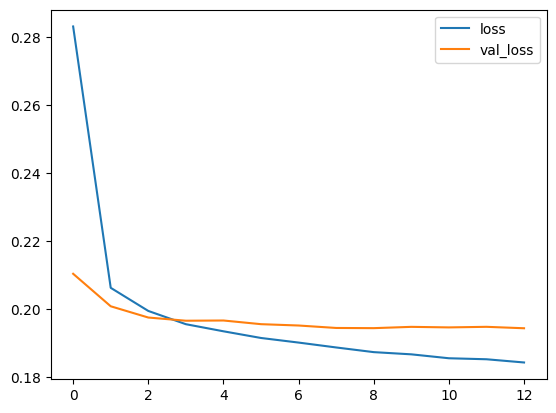

In [8]:
model = keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=input_shape),
    layers.Dense(64, activation='relu'),    
    layers.Dense(1)
])
model.compile(
    optimizer='adam',
    loss='mae',
)
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=512,
    epochs=50,
    callbacks=[early_stopping]
)
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()))

# 4) Train and Interpret

Was this an improvement compared to training without early stopping?

---->>>The early stopping callback did stop the training once the network began overfitting. Moreover, by including restore_best_weights we still get to keep the model where validation loss was lowest.